In [1]:
%pylab inline


from __future__ import division
from scipy.integrate import quad
from copy import copy, deepcopy
from scipy import optimize
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets

class demandFunc():
    
    def __init__(self,**params):
        for key in params:
                setattr(self, key, params[key])

    def demand(self, P):
        
        return self.multiplier*(P**-self.elasticity)
        
    def invDemand(self, Q):
        
        return (self.multiplier/Q)**(1/self.elasticity)

    def demandCurve(self, Pvec):
        '''
        Pvec is a vector of prices
        '''
        return map(self.demand, Pvec)
    
    def invDemandCurve(self, Qvec):
        '''
        Qcev is a vector of quantities
        '''
        return map(self.invDemand, Qvec)
        
        
class supplyFunc():

    def __init__(self,interval_points):
        '''
        interval points is a set of tupples (Q,P)
        '''
        self.interval_points = copy(interval_points)
        self.interval_points.sort(reverse=True)
        
    def supply(self,P):

        highest_q = self.interval_points[0][0]
        for q,p in self.interval_points:
            if p > P:
                highest_q = q
                continue
            if p <= P:
                return highest_q
        return highest_q
            
    def invSupply(self, Q):
               
        highest_p = self.interval_points[0][1]
        for q,p in self.interval_points:
            if q < Q:
                return p
            if q >= Q:
                highest_p = p
                continue
        return highest_p

    def supplyCurve(self, Pvec):
        '''
        Pvec is a vector of prices
        '''
        return map(self.supply, Pvec)
    
    def invSupplyCurve(self, Qvec):
        '''
        Qvec is a vector of quantities
        '''
        return map(self.invSupply, Qvec)
    
class market(object):
    
    def __init__(self, demandFunc, supplyFunc):
        self.demandFunc, self.supplyFunc = demandFunc, supplyFunc
        '''
        if ad < az:
            raise ValueError('Insufficient demand.')
        '''
        self.findEQ()
        self.find_cSurplus()
    
    def findEQ(self):
        "Return equilibrium price"
        self.ranges = ((1,(self.supplyFunc.interval_points[0][1])*1.2))
        optimalFunc = lambda q : np.abs(self.demandFunc.invDemand(q) - self.supplyFunc.invSupply(q))
        results = optimize.brute(optimalFunc, (self.ranges, ), full_output=True,
                              finish=optimize.fmin)
        self.equilibriumQ = results[0][0]
        self.equilibriumP = self.demandFunc.invDemand(self.equilibriumQ)
    
    def find_cSurplus(self):
        "Compute consumer surplus"
        intDemand, errorD = quad(self.demandFunc.invDemand, 1, self.equilibriumQ)
        intSupply, errorS = quad(self.supplyFunc.invSupply, 1, self.equilibriumQ)
        intDemand += self.demandFunc.invDemand(1) #TODO: make sure this is correct
        self.consumerSurplus = intDemand - intSupply
        

Populating the interactive namespace from numpy and matplotlib


/home/alex/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
class scenarioSimulator(object):
    
    def __init__(self, market):
        self.market              = market
        self.grid                = np.linspace(1,(self.market.supplyFunc.interval_points[0][1]*1.2), 300)
        self.surplusParams       = {
                                    'facecolor':'green',
                                    'alpha'    :.3,
                                    'label'    :'surplus'
                                    }
        self.surplusAddParams = {
                                    'color'  :  'blue',
                                    'alpha'  :  .3,
                                    'label'  :  'new surplus'
                                    }
        self.surplusLossParams = {
                                    'color'  :  'red',
                                    'alpha'  :  .2,
                                    'label'  :  'lost surplus'
                                    }        
        self.titlefont           = {
                                    'family' : 'serif',
                                    'color'  : 'black',
                                    'weight' : 'bold',
                                    'size'   : 16,
                                    }
        self.labelfont           = {
                                    'family' : 'sans-serif',  # (cursive, fantasy, monospace, serif)
                                    'color'  : 'black',       # html hex or colour name
                                    'weight' : 'normal',      # (normal, bold, bolder, lighter)
                                    'size'   : 14,            # default value:12
                                    }
        self.linesize            = {
                                    'lw'     : 2,
                                    'alpha'  : 0.6
                                   }
        self.dottedline          = {
                                    'lw'     :  1,
                                    'alpha'  :  1,
                                    'ls'     :  'dashed',
                                    'color'  :  'black'
                                    }
     
        self.plotPoints = [{'equilibrium' : (market.equilibriumQ, market.equilibriumP)},{}]
    
    def plotDemand(self,ax):
        return ax.plot(self.grid, self.market.demandFunc.invDemandCurve(self.grid), label = 'demand', **self.linesize)
        
    def plotSupply(self,ax):
        return ax.plot(self.grid, self.market.supplyFunc.invSupplyCurve(self.grid), label = 'supply', **self.linesize)
    
    def plotHouseholds(self,ax,priceLevel = None):
        
        qLevel = self.market.demandFunc.demand(priceLevel)
        yLine  = lambda q : 0
        for i in np.linspace(0,qLevel,qLevel*2,endpoint=False):
            pointList = [np.array([i,i+.5]), np.linspace(i,i+.5,200)]
            prices    = self.market.demandFunc.invDemandCurve(np.array([i+.5]))
            pLine     = lambda p : prices[0]
            ax.fill_between(
                            pointList[1],
                            pLine(pointList[1]),
                            yLine(pointList[1]),
                            color = 'blue', alpha = .15
                            )
            ax.fill_between(
                            pointList[0],
                            pLine(pointList[0]),
                            yLine(pointList[0]),
                            where = self.market.demandFunc.invDemandCurve(pointList[0]) <= prices[0],
                            color = 'blue', alpha = .4
                            )
    
    def plotDemandShift(self,ax,demandShift = None,populationShift = None):
        self.demandShiftMarket = deepcopy(self.market)
        self.demandShiftMarket.demandFunc.multiplier += demandShift
        self.demandShiftMarket.findEQ()
        self.plotPoints[0]['new equilibrium'] = ((self.demandShiftMarket.equilibriumQ, self.demandShiftMarket.equilibriumP))
        self.demandShiftPlot   = self.demandShiftMarket.demandFunc.invDemandCurve(self.grid)
        ax.plot(self.grid, self.demandShiftPlot, label = 'new demand', **self.linesize)
    
    def plotSupplyShift(self,ax,supplyShift = None):
        self.supplyShiftMarket = deepcopy(self.market)
        self.supplyShiftMarket.supplyFunc.interval_points = [(i,j+supplyShift) for i,j in self.market.supplyFunc.interval_points] 
        self.supplyShiftMarket.findEQ()
        self.plotPoints[0]['new equilibrium'] = ((self.supplyShiftMarket.equilibriumQ, self.supplyShiftMarket.equilibriumP))
        self.supplyShiftPlot   = self.supplyShiftMarket.supplyFunc.invSupplyCurve(self.grid)
        ax.plot(self.grid, self.supplyShiftPlot, label = 'new supply', **self.linesize)
    
    def plotSurplus(self,ax,price = None):
        try:
            ax.fill_between(
                            self.grid,
                            self.market.demandFunc.invDemandCurve(self.grid), 
                            self.market.supplyFunc.invSupplyCurve(self.grid), 
                            where = self.market.demandFunc.invDemandCurve(self.grid) > np.maximum(price,self.market.equilibriumP), 
                            **self.surplusParams
                            )
        except AttributeError:
            pass
        
    def plotSupplyChangeSurplus(self,ax,supplyShift = None):
        try:
            if supplyShift >= 0:
                ax.fill_between(
                                self.grid,
                                self.market.supplyFunc.invSupplyCurve(self.grid), 
                                np.minimum(self.supplyShiftMarket.supplyFunc.invSupplyCurve(self.grid),self.market.demandFunc.invDemandCurve(self.grid)),
                                where = self.market.demandFunc.invDemandCurve(self.grid) > self.supplyShiftMarket.equilibriumP, 
                                **self.surplusLossParams
                                )      
            else:  
                ax.fill_between(
                                self.grid,
                                self.supplyShiftMarket.supplyFunc.invSupplyCurve(self.grid), 
                                np.minimum(self.market.supplyFunc.invSupplyCurve(self.grid), self.market.demandFunc.invDemandCurve(self.grid)), 
                                where = self.market.demandFunc.invDemandCurve(self.grid) > self.supplyShiftMarket.equilibriumP, 
                                **self.surplusAddParams
                                )        
        except AttributeError:
            pass
        
    def plotDemandChangeSurplus(self,ax,demandShift = None):
        try:
            if demandShift >= 0:
                ax.fill_between(
                                self.grid,
                                self.demandShiftMarket.demandFunc.invDemandCurve(self.grid), 
                                np.maximum(self.market.demandFunc.invDemandCurve(self.grid), self.market.supplyFunc.invSupplyCurve(self.grid)),
                                where = self.demandShiftMarket.demandFunc.invDemandCurve(self.grid) > self.demandShiftMarket.equilibriumP,
                                **self.surplusAddParams
                                )        
            else:
                ax.fill_between(
                                self.grid,
                                self.market.demandFunc.invDemandCurve(self.grid), 
                                np.maximum(self.demandShiftMarket.demandFunc.invDemandCurve(self.grid), self.market.supplyFunc.invSupplyCurve(self.grid)), 
                                where = self.market.demandFunc.invDemandCurve(self.grid) > self.market.equilibriumP, 
                                **self.surplusLossParams
                                )        
        except AttributeError:
            pass

        
    def annotate(self):
        
        for i, ax in enumerate(self.fig.axes):
            plotPoints = self.plotPoints[i]
            for key,value in plotPoints.iteritems():
                if key == 'equilibrium' or key == 'new equilibrium':
                    print('yes')
                    ax.plot(value[0], value[1], 'or')
                    ax.annotate(str(key), (value[0],value[1]), (value[0]+value[0]/10,value[1]+value[0]/10) )
                    continue
                ax.plot(value[0], value[1], **self.dottedline)
                ax.text(value[0][-1], value[1][-1], str(key), **self.labelfont)
        self.plotPoints = [{'equilibrium' : (self.market.equilibriumQ, self.market.equilibriumP)}, {}]
                
    def drawPrice(self,price):
        
        self.drawFigure(priceLevel = price,EQ = False)
        points = [i for i in self.grid if i < self.market.demandFunc.demand(price)]
        self.plotPoints[0]['price'] = (points,[price]*len(points))
        
    def drawQuantity(self,quantity):
        
        self.drawFigure(priceLevel = self.market.demandFunc.invDemand(quantity),EQ=False)
        points = [quantity] * 50
        self.plotPoints[0]['quantity'] = (points, np.linspace(0, self.market.demandFunc.invDemand(quantity),50).tolist())
        
    def drawHouseholds(self,price):
        
        self.drawFigure(priceLevel = price, households = True, showSurplus = False)
        points = [self.market.demandFunc.demand(price)] * 50
        self.plotPoints[0]['quantity supplied'] = (points, np.linspace(0, price,50).tolist())
        del self.plotPoints[0]['equilibrium']
        
    def drawSupplyShift(self, shift = 1):
        
        self.drawFigure(supplyShift=shift)
    
    def drawDemandShift(self,shift=1):
        
        self.drawFigure(demandShift=shift)
        
    def drawShifts(self, demandShift=1, supplyShift=1):

        self.drawFigure(demandShift=demandShift, supplyShift=supplyShift)

    def drawCapitalExpTradeoff(self,budget,split,otherMarket=None):
        
        supplyShift1 = -1*budget*split
        supplyShift2 = -1*budget*(1-split)
        
        self.drawFigure(supplyShift1=supplyShift1,supplyShift2=supplyShift2,numPlots=2,otherMarket=otherMarket,
                      priceLevel=None,price2=None)
        self.fig.suptitle('Capital Expenditure Tradeoff')
        
    def drawPopulationShift(self,size,away=False):
        
        if away:
            size=-size
        demandShift1 = size
        demandShift2 = -size
        
        self.drawFigure(demandShift1=demandShift1,demandShift2=demandShift2,numPlots=2,otherMarket=None,
                      priceLevel=None,price2=None)
        
    def drawOptimalTradeoff(self,totalSupply,otherMarket = None):
        #need to add back integrals for Q < 1 for precise calculation - but this is still OK for graphing!
        if self.market.equilibriumQ + otherMarket.equilibriumQ <= totalSupply:
            raise ValueError('totalSupply is too large, there is no constraint!')
        surplusEquation1 = lambda q: self.market.demandFunc.invDemand(q) - self.market.supplyFunc.invSupply(q)
        surplusEquation2 = lambda q: otherMarket.demandFunc.invDemand(q) - otherMarket.supplyFunc.invSupply(q)
        
        intDemand1 = lambda q: quad(surplusEquation1, 1, q)[0] # + self.market.demandFunc.invDemand(q)
        intDemand2 = lambda q: quad(surplusEquation2, 1, q)[0] # + otherMarket.demandFunc.invDemand(q)
        
        optimalFunction = lambda q_pct : -1*(intDemand1(q_pct*totalSupply) + intDemand2((1-q_pct)*totalSupply))
        result = optimize.brute(optimalFunction,((.001,.999), ),full_output=True,finish=optimize.fmin)
        self.drawTradeoff(totalSupply,result[0],otherMarket = otherMarket)
        
    def drawTradeoff(self,totalSupply,firstMarketFrac,otherMarket = None):
        
        if firstMarketFrac < 0 or firstMarketFrac > 1:
            raise ValueError('Input must be numeric between 0 and 1 inclusive.')
        quant1 = totalSupply * firstMarketFrac
        quant2 = totalSupply - quant1
        price1 = self.market.demandFunc.invDemand(quant1)
        if otherMarket is not None:
            price2 = otherMarket.demandFunc.invDemand(quant2)
        else:
            price2 = self.market.demandFunc.invDemand(quant2)
        self.drawFigure(priceLevel=price1,price2=price2,otherMarket=otherMarket,numPlots=2,EQ=False)
            
    def drawFigure(self, numPlots=1, EQ = True, **kwargs):
        fig, ax_array = plt.subplots(1, numPlots,figsize = (5*numPlots,5),sharey=True)
        for i,ax in enumerate(np.ravel(ax_array)):
            
            ax.set_xlim([1,self.market.supplyFunc.interval_points[0][1]])
            ax.set_ylim([1,self.market.supplyFunc.interval_points[0][0]*2.5])
            try:
                kwargs['demandShift'] = kwargs['demandShift'+str(i+1)]
            except KeyError:
                pass
            try:
                kwargs['supplyShift'] = kwargs['supplyShift'+str(i+1)]
            except KeyError:
                pass
            if i == 0:
                self.drawAxes(ax,EQ=EQ,**kwargs)
                continue
            if kwargs['otherMarket'] is not None:
                self.tempMarket = deepcopy(self.market)
                self.market = deepcopy(kwargs['otherMarket'])
            del kwargs['priceLevel']
            
            self.drawAxes(ax,EQ=EQ,priceLevel=kwargs['price2'], **kwargs)
            if kwargs['otherMarket'] is not None:
                self.market = deepcopy(self.tempMarket)
        self.fig=fig
        
    def drawAxes(self,ax,showSurplus=True, supplyShift = None, demandShift = None, households = None, **kwargs):
        
        #unpack key word arguments
        for i in kwargs:
            try:
                exec('%s = %s' % (i, repr(kwargs[i])))
            except SyntaxError:
                continue
        
        #set up titles / markings for graph
        title = 'Supply and Demand for Water'
        xlab = 'Quantity of Water (Mcm/capita)'
        
        self.plotDemand(ax)
        if households:
            self.plotHouseholds(ax,priceLevel=priceLevel)
            title = "Individual Household's Demand for Water"
            xlab = 'Quantity of Water (cm)'
        else:
            self.plotSupply(ax)
        if supplyShift:
            self.plotSupplyShift(ax,supplyShift=supplyShift)
        if demandShift:
            self.plotDemandShift(ax,demandShift=demandShift)
        if showSurplus:
            if not EQ:
                self.plotSurplus(ax,price=array(priceLevel))
                title = 'Constrained Water Markets'
                self.titlefont['size']=12
            else:
                self.plotDemandChangeSurplus(ax, demandShift=demandShift)
                self.plotSupplyChangeSurplus(ax, supplyShift=supplyShift)
                title = 'Water Market Shift'
                self.plotSurplus(ax, price = self.market.equilibriumP)
        
        ax.set_title(title, fontdict=self.titlefont) 
        ax.set_xlabel(xlab, fontdict=self.labelfont)
        ax.set_ylabel('Price ($/mcm)', fontdict=self.labelfont)
        ax.legend(loc='best', frameon=False, fontsize=12, markerscale=.6,ncol=2,columnspacing=.8)
        
        self.supplyShiftMarket, self.demandShiftMarket= None, None
        


In [3]:
supplyLevels = [(0,2),(3,4),(6,7)]
highlandsSupplyLevels = [(i,j+3) for i,j in supplyLevels]
demand_parameters = {'multiplier':8,'elasticity':.6}
Market = market(demandFunc(**demand_parameters), supplyFunc(supplyLevels))
lowAltMarket = market(demandFunc(**demand_parameters), supplyFunc(highlandsSupplyLevels))
graphMaker = scenarioSimulator(Market)

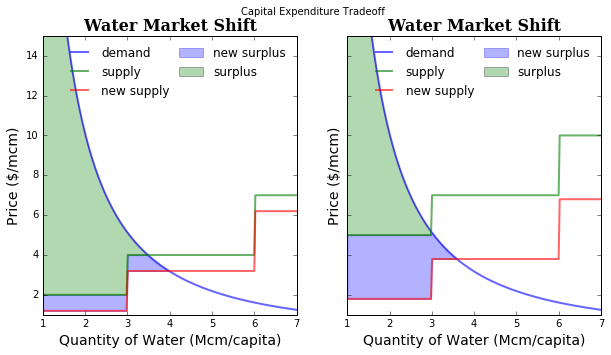

In [4]:
'''
graphMaker.drawPrice(5)
graphMaker.annotate()

graphMaker.drawQuantity(2.5)
graphMaker.annotate()

graphMaker.drawDemandShift(4)
graphMaker.annotate()

graphMaker.drawDemandShift(-2)
graphMaker.annotate()

graphMaker.drawSupplyShift()
graphMaker.annotate()

graphMaker.drawSupplyShift(-2)
graphMaker.annotate()

graphMaker.drawHouseholds(4)
graphMaker.annotate()

graphMaker.drawPopulationShift(2,away=True)

graphMaker.drawCapitalExpTradeoff(2,.3)

graphMaker.drawFigure()

graphMaker.drawPrice(10.07)

graphMaker.drawTradeoff(4,.4)

graphMaker.drawOptimalTradeoff(4, otherMarket=lowAltMarket)

'''
graphMaker.drawCapitalExpTradeoff(4, .2,otherMarket=lowAltMarket)




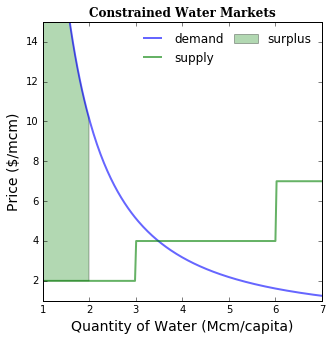

In [5]:
interact(graphMaker.drawPrice,price=(1,10,.1))

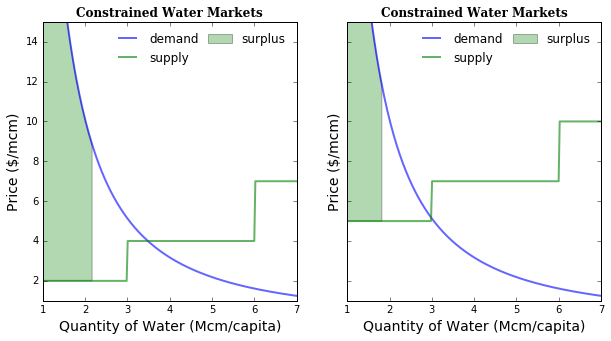

In [6]:
interact(graphMaker.drawOptimalTradeoff,totalSupply=(1,6,.2), otherMarket=fixed(lowAltMarket))

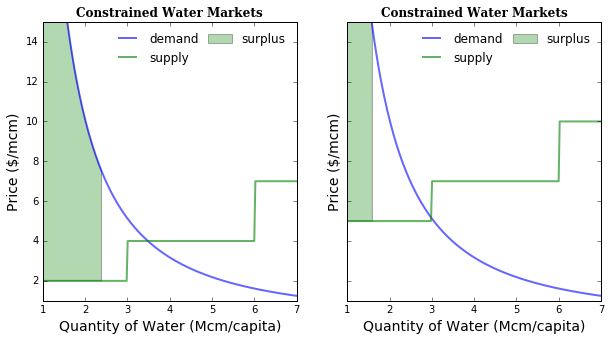

In [7]:
interact(graphMaker.drawTradeoff,totalSupply=(1,6,.2), firstMarketFrac=(.001,.999,.1),otherMarket=fixed(lowAltMarket))

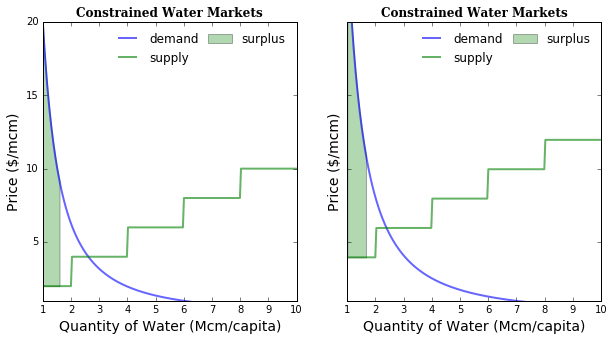

In [8]:
kwargDict = {
             'optimize':'True', 
             'waterSupply':4,
             'waterSharePct':.4,
             'supplyChange':2,
             'demandChange':1
            }


def buildSupplyPoints(width, height, steps):
    supplyPoints = [(0,height)] 
    supplyPoints.extend([(supplyPoints[0][0]+width*(i+1),supplyPoints[0][1]+height*(i+1)) for i in range(int(steps/width))])
    return supplyPoints

def makeKwargs(kwargDict):
    mixMaxRangeTupples = {}
    for k,v in kwargDict.iteritems():
        try:
            mixMaxRangeTupples[k]=(v-2*v,v+2*v,v/50)
        except TypeError:
            continue
    return mixMaxRangeTupples

@interact(**makeKwargs(kwargDict))
def compareMarketsSimple(optimize=('True','False'),waterSharePct=None,waterSupply=None,supplyChange=None,demandChange=None):
    supplyLevels = buildSupplyPoints(2,2,8)
    newSupplyLevels = [(i,j+supplyChange) for i,j in supplyLevels]
    demand_parameters = {'multiplier':6,'elasticity':.6}
    newDemand_parameters = {'multiplier':6+demandChange,'elasticity':.6}
    Market = market(demandFunc(**demand_parameters), supplyFunc(supplyLevels))
    newMarket = market(demandFunc(**newDemand_parameters), supplyFunc(newSupplyLevels))
    graphMaker = scenarioSimulator(Market)
    if optimize == 'True':
        graphMaker.drawOptimalTradeoff(totalSupply = waterSupply, otherMarket=newMarket)
    else:
        graphMaker.drawTradeoff(waterSupply,waterSharePct, otherMarket=newMarket)

        
kwargDict1 = {
             'optimize':'True',
             'waterSupply':40, 
             'waterSharePct':.4, 
             'demandMult1':60,
             'demandMult2':60,
             'demandElas1':.6,
             'demandElas2':.6,
             'stepWidth1':2,
             'stepHeight':2,
             'steps':8,
             'supplyChange':2,
             'demandChangeM':1,
             'demandChangeE':.1,
            }

In [9]:
test = (np.array([1,2]).tolist(),[4,3])
test[0][1]

2